In [113]:
# Install libraries

# %pip install torch torchvision matplotlib pillow numpy

import os
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms.v2 as v2
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from typing import Tuple, Dict
from collections import defaultdict
from PIL import Image
import time


In [114]:
# Setting up train, test folders paths

train_dataset = "./Intel_Image_Classification/train_segment/originals"
test_dataset  = "./Intel_Image_Classification/test_segment"

In [115]:
# Figguring out (height, width, imager/class, format) of images from either training or testing sets

def get_info_from_data_set(path: str) -> Tuple[int, int, Dict[str, int], Dict[str, int]]:
    heights = []
    widths  = []
    formats = defaultdict()
    images_per_class = dict()

    for image_class in os.listdir(path):
        image_class_dir = os.path.join(path, image_class)
        class_images    = os.listdir(image_class_dir)

        images_per_class[image_class] = len(class_images)

        for image in class_images:
            image_path     = os.path.join(image_class_dir, image)
            image_as_array = np.array(Image.open(image_path))
            
            h, w, c = image_as_array.shape

            heights.append(h)
            widths.append(w) 

            image_name, image_extension = os.path.splitext(image_path)

            if image_extension not in formats.keys():
                formats[image_extension] = 0
            else:
                formats[image_extension] += 1
            

    average_height = sum(heights) / len(heights)
    average_wifth  = sum(widths) / len(widths)

    return (round(average_height), round(average_wifth), images_per_class, formats)

In [116]:
(average_img_h, average_img_w, images_per_class, formats) = get_info_from_data_set(train_dataset)
print(f'average_height:   {average_img_h}')
print(f'average_width:    {average_img_w}')
print(f'formats:          {formats}')
print(f'images_per_class: {images_per_class}')

average_height:   150
average_width:    150
formats:          defaultdict(None, {'.jpg': 14033})
images_per_class: {'buildings': 2191, 'forest': 2271, 'glacier': 2404, 'mountain': 2512, 'sea': 2274, 'street': 2382}


In [117]:
# Creating training, testing datasets from the local dir
# Creating an iterator over random batches (DataLoader) 

# Set of transforms to be aplied
transform = v2.Compose([
    v2.ToImage(),       
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomHorizontalFlip(p=0.5),              
    v2.Resize(size=(round(average_img_h), round(average_img_w)))  
])

# Creating train, test sets from folder in root path
train_set = torchvision.datasets.ImageFolder(root=train_dataset, transform=transform)
test_set  = torchvision.datasets.ImageFolder(root=test_dataset,  transform=transform)

# Creating iterable dataloders
train_dataloader = DataLoader(train_set, batch_size=16, shuffle=True)
test_dataloader  = DataLoader(test_set,  batch_size=16,  shuffle=True)

print(f'batches_in_train_dataloader: {len(train_dataloader)}')
print(f'batches_in_test_dataloader:  {len(test_dataloader)}')

batches_in_train_dataloader: 878
batches_in_test_dataloader:  188


In [118]:
# Getting numeric, alpabetical labels from the dataset

labels_numbers_to_strings = {val: key for key, val in train_dataloader.dataset.class_to_idx.items()}
labels_strings_to_numbers = train_dataloader.dataset.class_to_idx

print(f'labels_numbers_to_strings: {labels_numbers_to_strings}')
print(f'labels_strings_to_numbers: {labels_strings_to_numbers}')

labels_numbers_to_strings: {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}
labels_strings_to_numbers: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


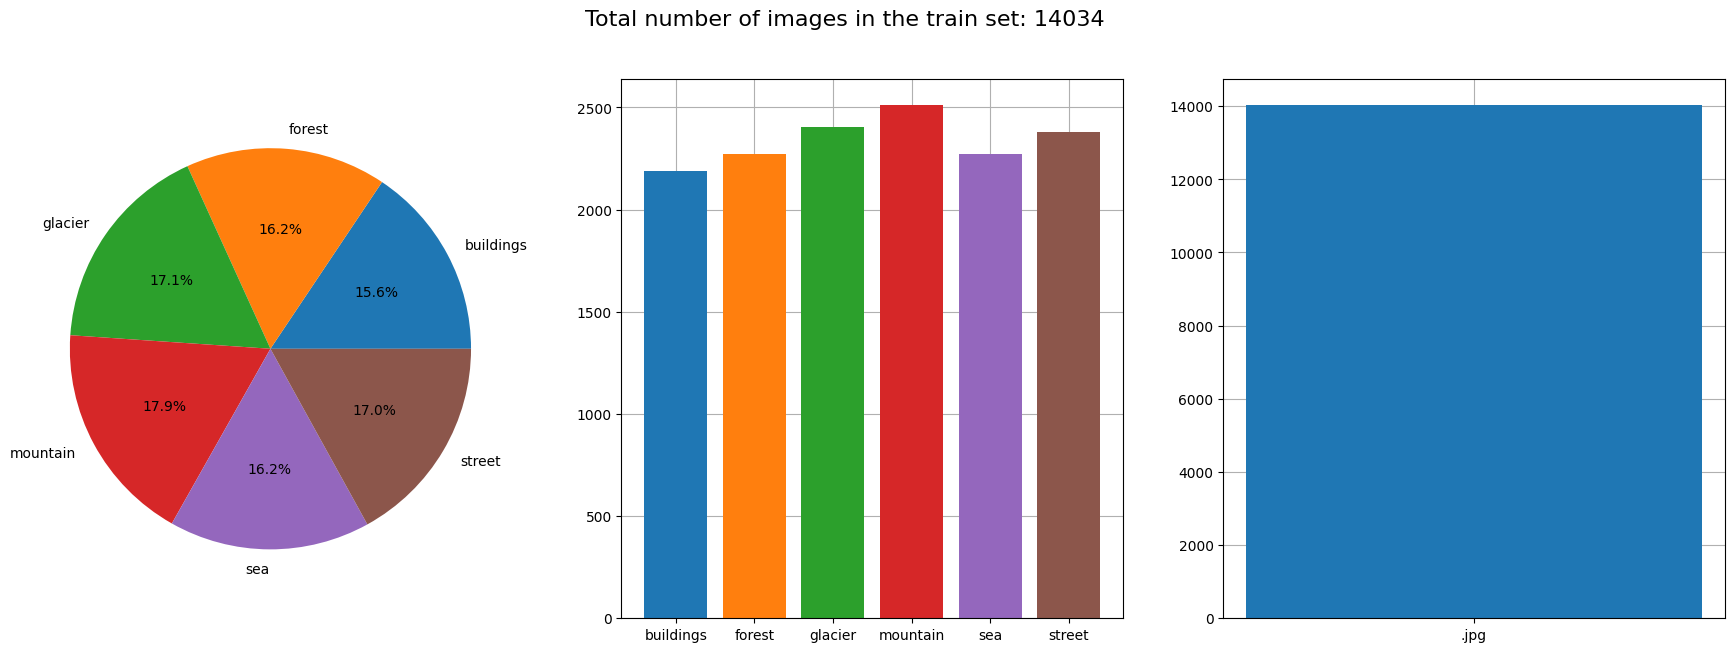

In [119]:
# Creating plots (1 row of 3 plots)
fig, ax = plt.subplots(1, 3, figsize=(22, 7))

# Creating a pie
wedges, texts, autotext = ax[0].pie(
    x      = list(images_per_class.values()), 
    labels = list(images_per_class.keys()) ,  
    autopct= lambda pct: f'{pct:.1f}%'
    ) 

# Remembering pie colors to use on the next plot
pie_colors = [wedge.get_facecolor() for wedge in wedges]

# Creating a bar plot for image/class distribution
ax[1].bar(
    images_per_class.keys(), 
    images_per_class.values(), 
    color  = pie_colors,
    zorder = 2
    )   
ax[1].grid()

# Creating a bar plot for img type distribution
ax[2].bar(
    formats.keys(), 
    formats.values(), 
    zorder = 2
    ) 
ax[2].grid()

fig.suptitle(f'Total number of images in the train set: {sum(images_per_class.values())}', fontsize=16)

plt.show()

In [120]:
# Used for displaying multiple images on a single pyplot
def print_images(images_as_vectors, labels_strings=None, labels_numeric=None):
    if labels_strings != None and labels_numeric != None:
        raise ValueError('Optional labels_strings, labels_numeric cannot both be set, use 1 of them')   
    
    if labels_strings != None:
        if len(images_as_vectors) != len(labels_strings):
            raise ValueError("Both images_as_vectors and labels_strings supposed to have the same size")

    if labels_strings != None:
        if len(images_as_vectors) != len(labels_strings):
            raise ValueError("Both images_as_vectors and labels_numeric supposed to have the same size")
    
    # Create a single plot for multiple images (one subplot per image)
    # The number of columns in the plot is determined by the number of images to display
    fig, axes = plt.subplots(ncols=len(images_as_vectors), figsize=(20, 20))

    # Setting up labels for images
    labels = [''] * len(images_as_vectors)
    if labels_strings != None:
        labels = labels_strings
    elif labels_numeric != None:
        labels = [labels_numbers_to_strings[int(i)] for i in labels_numeric]

    # Plotting images
    for index, image_as_vector in enumerate(images_as_vectors):

        # image_as_vector is expected to have shape of [chanels, h, w], since it is from datLoader
        # Pyplot expects images to have rgb chanels in the last dimention, so transpose
        image_as_vector = np.transpose(image_as_vector, (1, 2, 0))

        # If 1 image is passed, creating subplots of length 1 will create a normal subplot
        # It wont be subscriptable, so it [] is used on it, i will result in a crash
        # So need a separate if
        if len(images_as_vectors) == 1:
            fig.set_size_inches(3, 3)

            # Plotting the image
            axes.imshow(image_as_vector)
            axes.title.set_text(labels[index])
            axes.title.set_fontsize(25)

            # Removing the x and y ticks for a cleaner display
            axes.set_xticks([])
            axes.set_yticks([])
        else:
            # Plotting the image
            axes[index].imshow(image_as_vector)
            axes[index].title.set_text(labels[index])
            axes[index].title.set_fontsize(25)

            # Removing the x and y ticks for a cleaner display
            axes[index].set_xticks([])
            axes[index].set_yticks([])
    
    plt.show()

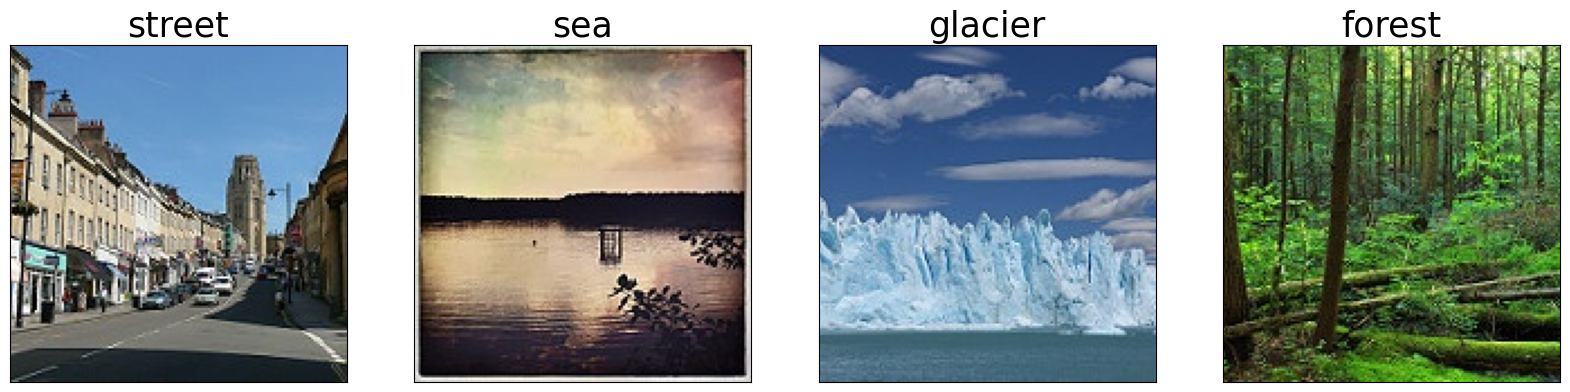

In [121]:
# Displaying some of the augmented images

first_batch = next(iter(train_dataloader))
first_batch_images         = first_batch[0]
first_batch_labels_numeric = first_batch[1]

print_images(first_batch_images[:4], labels_numeric=first_batch_labels_numeric)

In [122]:
# ======================================================================================================================================================================================
# ======================================================================================================================================================================================
# ======================================================================================================================================================================================

In [123]:
# == Model Description =========================================================================================================

# self.conv1  = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
#   Transforming 3-channeled image into 6 conv maps, therefor into 6 chanels. Each convolution window if 5x5
#   In other words:
#       applying 6 filters on a rgb image

# self.pool1  = nn.MaxPool2d(kernel_size=2, stride=2)
#   Received 6 concolutions form conv1, apllying 2x2 pooling on them
#   In the end have 6 convolutions but kinda lossly compressed (pooled)

# self.conv2  = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
#   Same as conv1, but 6 layers in after conv1 and pool1, and 16 out.


# self.pool2  = nn.MaxPool2d(kernel_size=2, stride=2)
#   Same as pool1, but now working on 16 layers

# self.fc1    = nn.Linear(in_features=16*34*34, out_features=120)
#   Fully connected layer
#   We receive a vector of 16 * 34 * 34, why: 
#       1. 16 is the number of layes 
#       2. 34 x 34 is the size of a single conv to whitch eatch image was transofrmed after conv1, pool1 ...
#       3. 16 is the number of those convs for each image. So 1 iamge, if displayed as a vector, would have 16 * 34 * 34 dims
 

# self.fc2    = nn.Linear(in_features=120, out_features=84)
# self.fc3    = nn.Linear(in_features=84, out_features=len(labels_numbers_to_strings))
#   These 2 are just reducing the vectors, until a vector if shape len(labels_numbers_to_strings) is reached.
#   That vector represent end values for each class 

# ==============================================================================================================================

# def forward(self, inputs):
#     inputs is a tensor of shape (batch_size, c, h, w)

#     inputs = self.pool1(F.relu(self.conv1(inputs)))   <- first layer
#     inputs = self.pool2(F.relu(self.conv2(inputs)))   <- second layer

#     inputs = torch.flatten(inputs, 1) 
#       Since inputs is a batch, we only flatten each image representation of newly created convlotions 

#     inputs = F.relu(self.fc1(inputs))     <- fullt connected 1
#     inputs = F.relu(self.fc2(inputs))     <- fullt connected 2
#     inputs = self.fc3(inputs)             <- fullt connected 3
#     return inputs

In [124]:
class CNN_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1  = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool1  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2  = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool2  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1    = nn.Linear(in_features=16*34*34, out_features=120)
        self.fc2    = nn.Linear(in_features=120, out_features=84)
        self.fc3    = nn.Linear(in_features=84, out_features=len(labels_numbers_to_strings))

    def forward(self, inputs):
        inputs = self.pool1(F.relu(self.conv1(inputs)))
        inputs = self.pool2(F.relu(self.conv2(inputs)))
        inputs = torch.flatten(inputs, 1) # flatten all dimensions except batch
        inputs = F.relu(self.fc1(inputs))
        inputs = F.relu(self.fc2(inputs))
        inputs = self.fc3(inputs)
        return inputs


In [125]:
# Registering a gpu 

print(torch.cuda.get_device_properties())

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

_CudaDeviceProperties(name='NVIDIA GeForce RTX 3060 Ti', major=8, minor=6, total_memory=8191MB, multi_processor_count=38, uuid=d5fb8565-b5cf-a304-9b09-1ee3544b0753, L2_cache_size=3MB)
cuda:0


In [126]:
# Creating a model and moving onto a gpu

model = CNN_Model().to(device)
print(model)

CNN_Model(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=18496, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
)


In [127]:
loss_function = nn.CrossEntropyLoss()
# optimizer     = optim.Adam(model.parameters(), lr=0.001) 
optimizer     = optim.SGD(params=model.parameters(), lr=0.001, momentum=0.9)

In [128]:
# True Positives:  It is the case where we predicted -> Yes and the real output was also yes.
# True Negatives:  It is the case where we predicted -> No and the real output was also No.
# False Positives: It is the case where we predicted -> Yes but it was actually No.
# False Negatives: It is the case where we predicted -> No but it was actually Yes. 

# But since i have 6 classes, i will have tp, fp for all the 6 classes.
# All instances of fps or fns are considered to be fps

In [129]:
def get_tps_fps(predicted, golden_labels):

    tp_per_class = {key: 0 for key in labels_numbers_to_strings.keys()}
    fp_per_class = {key: 0 for key in labels_numbers_to_strings.keys()}
    
    # Number of times a class appeard, these are based on golden labels
    per_class_occur = {key: 0 for key in labels_numbers_to_strings.keys()}

    max_values, max_indices = torch.max(predicted, 1)

    assert(len(max_indices) == len(golden_labels))

    for i in range(len(max_indices)):
        predicted_label = max_indices[i]
        expexted_label  = golden_labels[i]
        # tp
        if predicted_label == expexted_label:
            tp_per_class[predicted_label.item()] += 1
        # fp
        elif predicted_label != expexted_label:
            fp_per_class[predicted_label.item()] += 1

        per_class_occur[expexted_label.item()] += 1

    return (tp_per_class, fp_per_class, per_class_occur)
    

In [145]:
def get_metrics(tps_per_class, fps_per_class, per_class_occur):
    # Recall
    recall_per_class = {key: 0 for key in labels_numbers_to_strings.keys()}
    for key in recall_per_class.keys():
        tp          = tps_per_class[key]
        class_occur = per_class_occur[key]
        recall_per_class[key] = 100 * tp / class_occur 

    # Precision
    precision_per_class = {key: 0 for key in labels_numbers_to_strings.keys()}
    for key in precision_per_class.keys():
        tp = tps_per_class[key]
        fp = fps_per_class[key]
        precision_per_class[key] = 100 * tp / (tp + fp)
    
    return (recall_per_class, precision_per_class)

In [146]:
# TODO: redo

# Testing the model on the testing set, calculating accuracy

def test_model(dataloader: DataLoader) -> Tuple[Dict[str, int], Dict[str, int]]:
    each_class_correct_predictions  = {label: 0 for label in labels_numbers_to_strings.keys()}
    each_class_occurance = {label: 0 for label in labels_numbers_to_strings.keys()}

    correct_predictions = 0
    total_predictions   = 0
    testing_loss        = 0

    for inputs, labels in dataloader:

        # Moving tensors onto a gpu
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Getiing a prediction
        batch_predictions = model(inputs)

        # Getting a predicted class for each input
        max_values, max_indices = torch.max(batch_predictions, 1)

        # Comparing predictions to the golden labels
        correct_predictions += (max_indices == labels).sum().item()
        total_predictions   += len(labels)
        testing_loss += loss_function(batch_predictions, labels).item()
    
        for i in range(len(labels)):  # Looping through each label in the batch
            label = labels[i].item()
            prediction = max_indices[i].item()
            each_class_correct_predictions[label] += (prediction == label)
            each_class_occurance[label] += 1

    accuracy = 100 * correct_predictions / total_predictions
    average_testing_loss = testing_loss / total_predictions 

    return (accuracy, average_testing_loss, each_class_correct_predictions, each_class_occurance)



In [148]:
# Training the model

n_epochs = 5

# Using these for logging
epoch_losses              = []
epoch_losses_test         = []
epoch_accuracies_on_test  = []

# For each class: List of triples, each triple per epoch
# List of triples, stores (acc, rec, prec)  
accuracy_recall_precision = {key: [] for key in labels_numbers_to_strings.keys()}

epoch_start_time    = 0     
model_training_time = 0    

print("[epoch, average_batch_loss, batch_recall, batch_precision, batch_precision, batch_time_spent, total_time_spent]")

for epoch in range(n_epochs):
    epoch_start_time = time.time()
    
    # These to track performance during each epoch
    training_loss       = 0.0
    correct_predictions = 0
    total_samples       = 0
    total_batches       = len(train_dataloader)

    tps_per_class     = {key: 0 for key in labels_numbers_to_strings.keys()}
    fps_per_class     = {key: 0 for key in labels_numbers_to_strings.keys()}
    per_class_occur   = {key: 0 for key in labels_numbers_to_strings.keys()}
    for inputs, labels in train_dataloader:
        # Moving tensors onto a gpu
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients (Reson for it: https://medium.com/@lazyprogrammerofficial/in-pytorch-why-do-we-need-to-call-optimizer-zero-grad-8e19fdc1ad2f#:~:text=zero_grad()%20method%20is%20used,respect%20to%20the%20model%20parameters.)
        optimizer.zero_grad()

        # Outputs -> Tensor.shape = (batch_size, number_of_possible_classes)
        outputs = model(inputs)

        # Loss, Backpropogation, Optimization
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        # Accesing loss value and storing it
        training_loss += loss.item()
        
        # tp, fp
        (current_batch_tps, current_batch_fps, current_batch_per_class_occur) = get_tps_fps(outputs, labels)

        # Adding current batch info into epoch info
        for key in current_batch_tps.keys():
            tps_per_class[key]   += current_batch_tps[key]
            fps_per_class[key]   += current_batch_fps[key]
            per_class_occur[key] += current_batch_per_class_occur[key]

    # Evaluating the previos epoch
    average_loss = training_loss / total_batches
    epoch_losses.append(average_loss)

    (recall_per_class, precision_per_class) = get_metrics(tps_per_class, fps_per_class, per_class_occur)

    # Store current epoch metrics for each class
    for key in accuracy_recall_precision.keys():
        recall    = recall_per_class[key]
        precision = precision_per_class[key]

        class_metrics = (recall, precision)
        accuracy_recall_precision[key].append(class_metrics)

    # Testing current state of the model
    (test_accuracy, testing_loss, each_class_correct_predictions, each_class_occurance) = test_model(test_dataloader)
    epoch_accuracies_on_test.append(test_accuracy)
    epoch_losses_test.append(testing_loss)
    # == REDO ========================================

    assert(epoch + 1 == len(accuracy_recall_precision[0]))

    # Calculating overall batch recall
    batch_recall = 0
    for key in accuracy_recall_precision.keys():
        last_epoch_results = accuracy_recall_precision[key][-1] # key, last triplet
        batch_recall += last_epoch_results[0] # recall
    batch_recall /= len(accuracy_recall_precision.keys())

    # Calculating overall batch recall
    batch_precision = 0
    for key in accuracy_recall_precision.keys():
        last_epoch_results = accuracy_recall_precision[key][-1] # key, last triplet
        batch_precision += last_epoch_results[1] # recall
    batch_precision /= len(accuracy_recall_precision.keys())
    

    # Logging time spent on the previous epoch
    epoch_time_spent_min = (time.time() - epoch_start_time) / 60
    model_training_time  += epoch_time_spent_min

    print(f'[{epoch + 1}/{n_epochs},         {average_loss:.4f},           {batch_recall:.4f},       {batch_precision:.4f},          {testing_loss:.4f}       {epoch_time_spent_min:.1f} min,          {model_training_time:.1f} min]')
    
print('Done Training')

[epoch, average_batch_loss, batch_recall, batch_precision, batch_precision, batch_time_spent, total_time_spent]
[1/5,         0.2247,           92.2783,       92.2865,          0.0479       0.3 min,          0.3 min]
[2/5,         0.1963,           93.4866,       93.5042,          0.0471       0.3 min,          0.5 min]
[3/5,         0.1658,           94.5730,       94.5844,          0.0515       0.3 min,          0.8 min]
[4/5,         0.1408,           95.2357,       95.2481,          0.0546       0.3 min,          1.0 min]
[5/5,         0.1151,           96.2530,       96.2545,          0.0579       0.3 min,          1.3 min]
Done Training


In [137]:
# ========== Transforming accuracy_recall_precision into usable structures ==================

# 1.  Overall Accuracy Over Epochs on Training Data
overall_accuracy_per_epoch = []
epoch_number = 0

for epoch_number in range(n_epochs):
    overall_accuracy = 0
    divider = 0
    
    for key, list_of_epochs_metrics_for_key in accuracy_recall_precision.items():    
        overall_accuracy += list_of_epochs_metrics_for_key[epoch_number][0]
        divider += 1
    overall_accuracy /= divider

    overall_accuracy_per_epoch.append(overall_accuracy)

print(f'Overall_accuracy_per_epoch: \n\t{overall_accuracy_per_epoch}')

# 2.  Training Loss Over Epochs
epoch_losses    # Alredy in a correct form

# 3.  Accuracy Over Epochs on Testing Data
...

# 4.  Testing Loss Over Epochs
...

# 5.  Each class Accuracy over Epochs on Training data
class_accuracy_per_epoch = {key: [] for key in labels_numbers_to_strings.keys()}

for epoch_number in range(n_epochs):
    for key, list_of_epochs_metrics_for_key in accuracy_recall_precision.items():
        x = list_of_epochs_metrics_for_key[epoch_number][0]
        class_accuracy_per_epoch[key].append(x)

print(f'Class_accuracy_per_epoch: \n\t{class_accuracy_per_epoch}')

# 6.  Each class Precicion over Epochs on Training data
class_precicion_per_epoch = {key: [] for key in labels_numbers_to_strings.keys()}

for epoch_number in range(n_epochs):
    for key, list_of_epochs_metrics_for_key in accuracy_recall_precision.items():
        x = list_of_epochs_metrics_for_key[epoch_number][1]
        class_precicion_per_epoch[key].append(x)

print(f'Class_precicion_per_epoch: \n\t{class_precicion_per_epoch}')

# 7.  Each class Recall over Epochs on Training data
class_recall_per_epoch = {key: [] for key in labels_numbers_to_strings.keys()}

for epoch_number in range(n_epochs):
    for key, list_of_epochs_metrics_for_key in accuracy_recall_precision.items():
        x = list_of_epochs_metrics_for_key[epoch_number][2]
        class_recall_per_epoch[key].append(x)

print(f'Class_recall_per_epoch: \n\t{class_recall_per_epoch}')

print()
print(accuracy_recall_precision)





Overall_accuracy_per_epoch: 
	[38.46275011817831, 58.11750105727898, 62.487975288256315, 65.72746237628189, 68.80212350914293]
Class_accuracy_per_epoch: 
	{0: [37.67660910518053, 51.82237117720989, 55.923202614379086, 60.82251082251082, 65.56561085972851], 1: [65.76637407157327, 79.47598253275109, 83.62892223738062, 85.46697038724373, 86.42251004912907], 2: [33.5438829787234, 53.63309352517986, 57.08841463414634, 60.68172810146651, 65.3953118792213], 3: [37.95596450870851, 56.55245496291063, 59.94704992435703, 62.98989898989899, 65.26970954356847], 4: [29.832935560859188, 40.51446945337621, 48.539465506525794, 53.0938123752495, 56.04195166438669], 5: [26.00073448402497, 66.7066346922462, 69.800796812749, 71.30985358132173, 74.11764705882354]}
Class_precicion_per_epoch: 
	{0: [10.953902327704245, 56.458238247375625, 62.48288452761296, 64.1259698767686, 66.13418530351437], 1: [42.88859533245267, 80.14090708938794, 80.9775429326288, 82.60678115367679, 85.20475561426684], 2: [41.9717138103

In [ ]:
# overall_accuracy += value




# 8.  Each class Accuracy over Epochs on Testing data
# 9.  Each class Precicion over Epochs on Testing data
# 10. Each class Recall over Epochs on Testing data

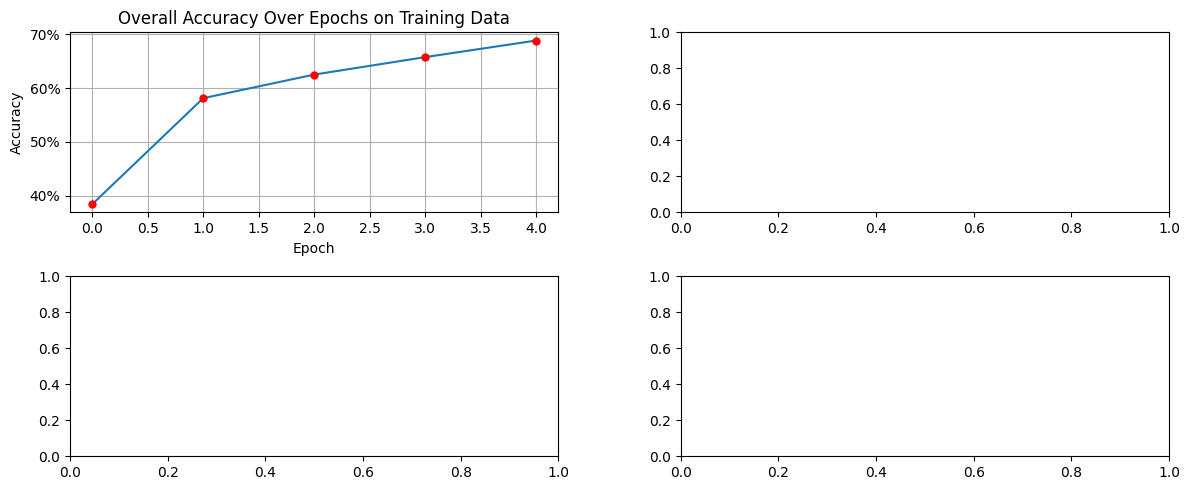

In [135]:
# Creating 4 subplots (2x2)
fig, ax = plt.subplots(2, 2, figsize=(12, 5)) 

# Plotting the first graph (Overall Accuracy Over Epochs on Training Data)
ax[0][0].plot(range(n_epochs), overall_accuracy_per_epoch, marker='o',  markerfacecolor='red', markeredgecolor='None')
ax[0][0].set_title("Overall Accuracy Over Epochs on Training Data")
ax[0][0].set_xlabel("Epoch")
ax[0][0].set_ylabel("Accuracy")
ax[0][0].yaxis.set_major_formatter(lambda x, pos: f'{int(x)}%')
ax[0][0].grid()

# # Plotting the second graph (Training Loss)
# ax[0][1].plot(range(n_epochs), epoch_losses, marker='o',  markerfacecolor='red', markeredgecolor='None')
# ax[0][1].set_title("Training Loss Over Epochs")
# ax[0][1].set_xlabel("Epoch")
# ax[0][1].set_ylabel("Loss")
# ax[0][1].grid()

# # Protting the third graph (Testing Accuracy)
# ax[1][0].plot(range(n_epochs), epoch_accuracies_on_test, marker='o',  markerfacecolor='red', markeredgecolor='None')
# ax[1][0].set_title("Accuracy Over Epochs on Testing Data")
# ax[1][0].set_xlabel("Epoch")
# ax[1][0].set_ylabel("Accuracy")
# ax[1][0].yaxis.set_major_formatter(lambda x, pos: f'{int(x)}%')
# ax[1][0].grid()

# # Protting the forth graph (Testing Loss)
# ax[1][1].plot(range(n_epochs), epoch_losses_test, marker='o',  markerfacecolor='red', markeredgecolor='None')
# ax[1][1].set_title("Testing Loss Over Epochs")
# ax[1][1].set_xlabel("Epoch")
# ax[1][1].set_ylabel("Loss")
# ax[1][1].grid()

# Adjusting layout to avoid overlap
plt.tight_layout()
plt.subplots_adjust(wspace=0.25)
plt.show()

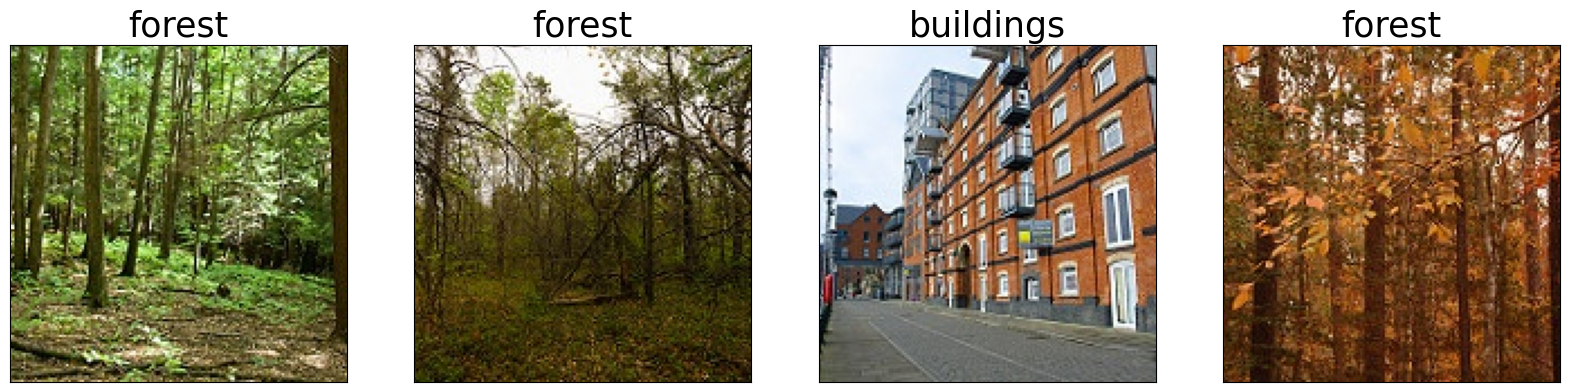

In [27]:
# Visualising a couple of images from the testing set

testing_batch = next(iter(test_dataloader))

testing_batch_images = testing_batch[0]
testing_batch_labels = testing_batch[1]

print_images(testing_batch_images[:4], labels_numeric=testing_batch_labels[:4])

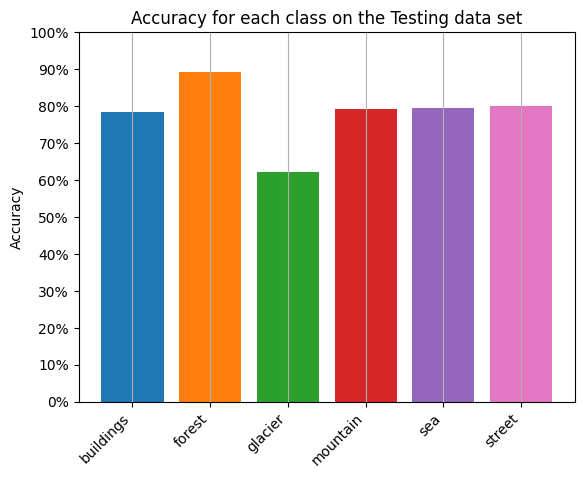

In [28]:
# Asserting 
if len(each_class_correct_predictions.values()) != len(each_class_occurance.values()):
    raise ValueError('Something happend to the labels')

fig, ax = plt.subplots()
classes   = labels_strings_to_numbers.keys()

# Calculating accuracy for each class
each_class_accuracy = []
for i in range(len(classes)):
    class_i_accuracy = (each_class_correct_predictions[i] / each_class_occurance[i])
    each_class_accuracy.append(class_i_accuracy)

colors = [
    "#1f77b4",  # Blue
    "#ff7f0e",  # Orange
    "#2ca02c",  # Green
    "#d62728",  # Red
    "#9467bd",  # Purple
    "#e377c2",  # Pink   
]

# Plotting
ax.bar(classes, each_class_accuracy, color=colors)
ax.set_ylabel('Accuracy')
ax.set_title(f'Accuracy for each class on the {"Testing data set"}')
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.yaxis.set_major_formatter(lambda x, pos: f'{int(x * 100)}%')
ax.grid(axis='x')

plt.xticks(rotation=45, ha='right')
plt.show()

In [29]:
# Manually testing on a random pictures from the training set

def test_on_a_random_picture(model: CNN_Model, dataloader: DataLoader):
    # Getting a random image
    random_test_batch = next(iter(dataloader))
    random_test_image   = random_test_batch[0][0]

    # Getting a string label for a random image from a numeric stored inside the batch
    random_test_image_label_numeric = random_test_batch[1][0].item()
    random_test_image_label_string  = labels_numbers_to_strings[random_test_image_label_numeric]

    # Image is of shape (3, 150, 150), since model takes in batched of shape (batch_size, 3, 150, 150)
    # we need to make it at least (1, 3, 150, 150), unsqueeze(0) does that
    prediction_vector = model(random_test_image.unsqueeze(0).to(device))
    prediction_max_value, prediction_index = torch.max(prediction_vector, 1)
    predicted_class   = labels_numbers_to_strings[prediction_index.item()]
    
    print(f'Predicted class: {predicted_class}')
    print(f'Actual class:    {random_test_image_label_string}')
    print_images([random_test_image], [predicted_class])
   

Predicted class: mountain
Actual class:    mountain


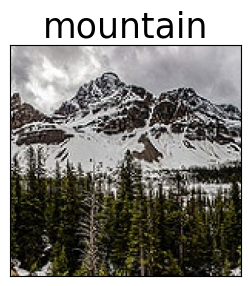

In [39]:
test_on_a_random_picture(model, test_dataloader)

In [ ]:
# TODO: maybe add recall, dont know if i need to, seems like accurasy is the most important thing for this type of classification

In [40]:
torch.save(model, 'model.pth')

In [3]:
model = torch.load('model.pth', weights_only=False)

In [4]:
model

CNN_Model(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=18496, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
)